Using device: cpu


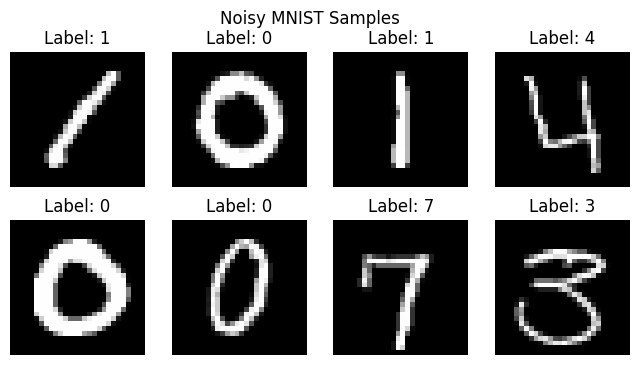


=== Baseline Training (No SMCNmF Reg) ===


/tmp/ipykernel_36/1086309540.py:76: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/tmp/ipykernel_36/1086309540.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/tmp/ipykernel_36/1086309540.py:115: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/5 | train_loss=0.2978 train_acc=0.9123 | val_loss=0.0855 val_acc=0.9745
Epoch 2/5 | train_loss=0.0694 train_acc=0.9791 | val_loss=0.0645 val_acc=0.9805
Epoch 3/5 | train_loss=0.0464 train_acc=0.9848 | val_loss=0.0548 val_acc=0.9835
Epoch 4/5 | train_loss=0.0311 train_acc=0.9898 | val_loss=0.0620 val_acc=0.9811
Epoch 5/5 | train_loss=0.0226 train_acc=0.9928 | val_loss=0.0531 val_acc=0.9844

=== Training with SMCNmF-Inspired Regularizer (lam=0.001) ===
Epoch 1/5 | train_loss=0.3403 train_acc=0.9091 | val_loss=0.0871 val_acc=0.9735
Epoch 2/5 | train_loss=0.1133 train_acc=0.9774 | val_loss=0.0719 val_acc=0.9789
Epoch 3/5 | train_loss=0.0945 train_acc=0.9823 | val_loss=0.0604 val_acc=0.9818
Epoch 4/5 | train_loss=0.0827 train_acc=0.9862 | val_loss=0.0848 val_acc=0.9754
Epoch 5/5 | train_loss=0.0779 train_acc=0.9877 | val_loss=0.0503 val_acc=0.9842

Summary:
     model  final_train_loss  final_train_acc  final_val_loss  final_val_acc  fc1_frobenius  fc1_nuclear  fc1_effective_rank
  

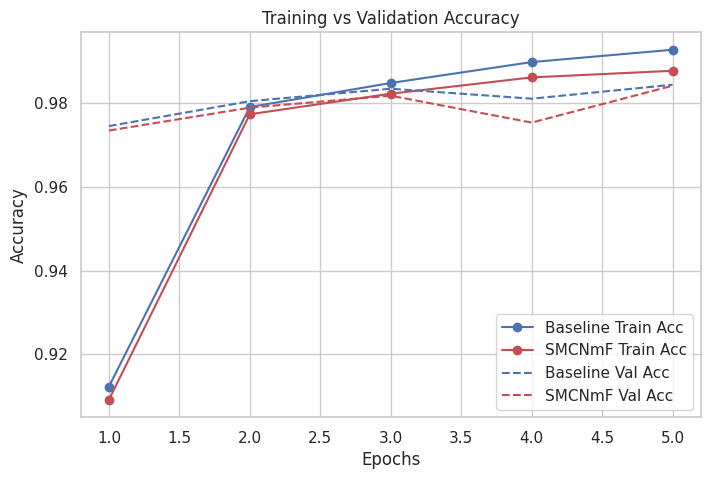

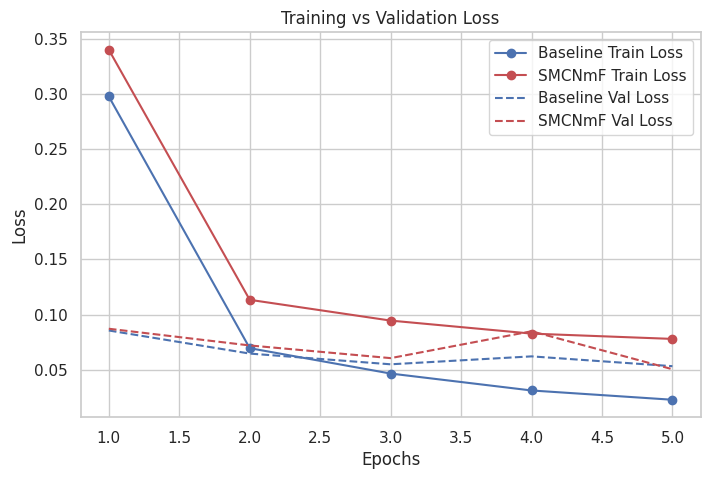

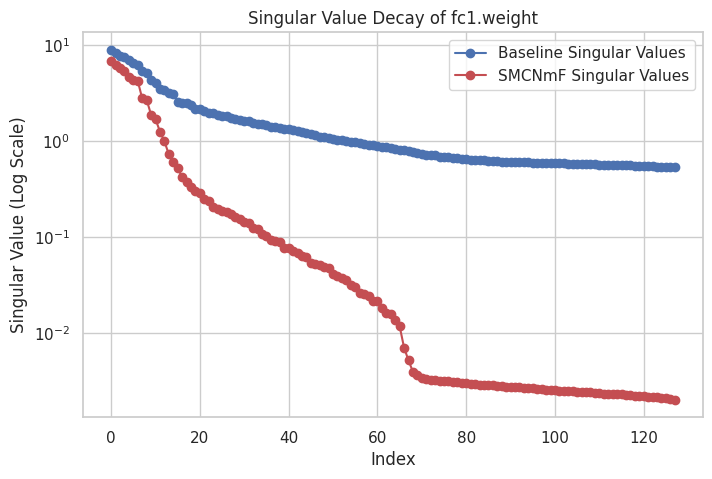

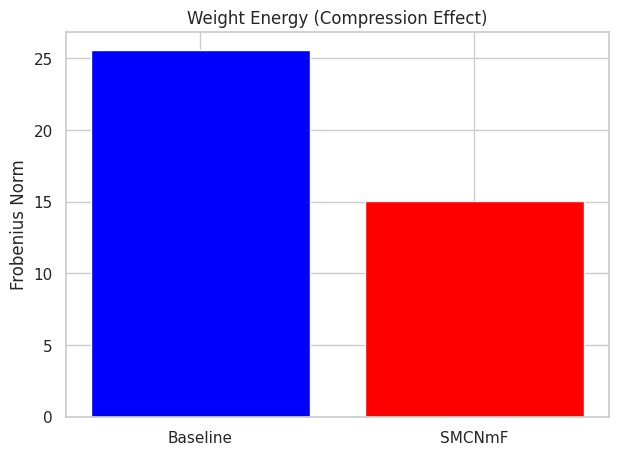

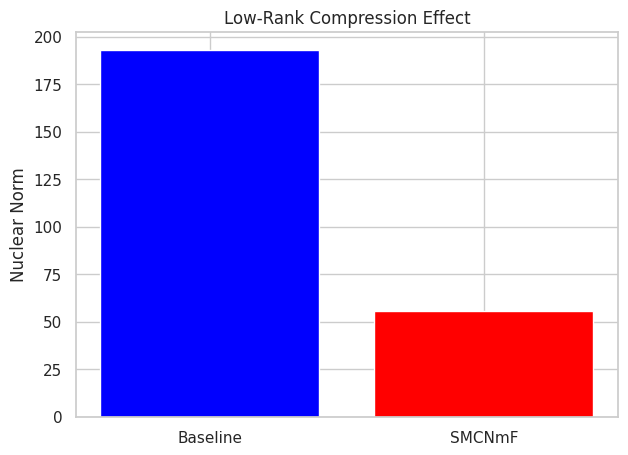


Saved 'cnn_baseline.pth' and 'cnn_smcnmf_reg.pth' in current folder.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_df  = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

X = train_df.drop("label", axis=1).values
y = train_df["label"].values

X = X.reshape(-1, 1, 28, 28) / 255.0
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_ds = TensorDataset(X_train, y_train)
val_ds   = TensorDataset(X_val, y_val)
test_ds  = torch.tensor(test_df.values.reshape(-1, 1, 28, 28) / 255.0, dtype=torch.float32)

batch_size = 256 if torch.cuda.is_available() else 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size*2, shuffle=False, num_workers=2, pin_memory=True)

plt.figure(figsize=(8, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(X[i][0], cmap="gray")
    plt.title(f"Label: {y[i].item()}")
    plt.axis("off")
plt.suptitle("Noisy MNIST Samples")
plt.show()

class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*14*14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def smcnmf_regularizer(weight_tensor, lam=1e-3):
    W = weight_tensor.view(weight_tensor.shape[0], -1).double()
    s = torch.linalg.svdvals(W)
    nuclear = torch.sum(s)
    frob = torch.norm(W, p='fro')
    return lam * (nuclear - frob)

def effective_rank(singular_values, thresh=1e-3):
    return (singular_values > thresh).sum().item()

def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=5, lam_reg=0.0):
    model = model.to(device)
    scaler = GradScaler()
    history = {'epoch': [], 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for ep in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()

            with autocast():
                out = model(xb)
                loss = criterion(out, yb)
                if lam_reg > 0:
                    reg = smcnmf_regularizer(model.fc1.weight, lam=lam_reg)
                    loss = loss + reg.to(loss.device).float()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * xb.size(0)
            _, preds = torch.max(out, 1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                with autocast():
                    out = model(xb)
                    loss = criterion(out, yb)
                val_loss += loss.item() * xb.size(0)
                _, preds = torch.max(out, 1)
                correct += (preds == yb).sum().item()
                total += xb.size(0)

        val_loss = val_loss / total
        val_acc = correct / total

        history['epoch'].append(ep)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {ep}/{epochs} | "
              f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

    return model, history

torch.manual_seed(0)
model_base = SmallCNN()
opt_base = optim.AdamW(model_base.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()
print("\n=== Baseline Training (No SMCNmF Reg) ===")
model_base, hist_base = train_model(model_base, opt_base, crit, train_loader, val_loader, epochs=5, lam_reg=0.0)

torch.manual_seed(0)
model_reg = SmallCNN()
opt_reg = optim.AdamW(model_reg.parameters(), lr=1e-3)
lam = 1e-3
print(f"\n=== Training with SMCNmF-Inspired Regularizer (lam={lam}) ===")
model_reg, hist_reg = train_model(model_reg, opt_reg, crit, train_loader, val_loader, epochs=5, lam_reg=lam)

with torch.no_grad():
    Wb = model_base.fc1.weight.data.clone().view(model_base.fc1.weight.shape[0], -1).double()
    Wr = model_reg.fc1.weight.data.clone().view(model_reg.fc1.weight.shape[0], -1).double()
    sb = torch.linalg.svdvals(Wb)
    sr = torch.linalg.svdvals(Wr)

    summary = {
        'model': ['baseline', 'smcnmf_reg'],
        'final_train_loss': [hist_base['train_loss'][-1], hist_reg['train_loss'][-1]],
        'final_train_acc': [hist_base['train_acc'][-1], hist_reg['train_acc'][-1]],
        'final_val_loss': [hist_base['val_loss'][-1], hist_reg['val_loss'][-1]],
        'final_val_acc': [hist_base['val_acc'][-1], hist_reg['val_acc'][-1]],
        'fc1_frobenius': [torch.norm(Wb, 'fro').item(), torch.norm(Wr, 'fro').item()],
        'fc1_nuclear': [sb.sum().item(), sr.sum().item()],
        'fc1_effective_rank': [effective_rank(sb, 1e-3), effective_rank(sr, 1e-3)]
    }
    df = pd.DataFrame(summary)
    print("\nSummary:")
    print(df.to_string(index=False))

sns.set(style="whitegrid")
epochs = hist_base['epoch']

plt.figure(figsize=(8,5))
plt.plot(epochs, hist_base['train_acc'], 'b-o', label="Baseline Train Acc")
plt.plot(epochs, hist_reg['train_acc'], 'r-o', label="SMCNmF Train Acc")
plt.plot(epochs, hist_base['val_acc'], 'b--', label="Baseline Val Acc")
plt.plot(epochs, hist_reg['val_acc'], 'r--', label="SMCNmF Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, hist_base['train_loss'], 'b-o', label="Baseline Train Loss")
plt.plot(epochs, hist_reg['train_loss'], 'r-o', label="SMCNmF Train Loss")
plt.plot(epochs, hist_base['val_loss'], 'b--', label="Baseline Val Loss")
plt.plot(epochs, hist_reg['val_loss'], 'r--', label="SMCNmF Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.semilogy(sb.cpu().numpy(), 'b-o', label="Baseline Singular Values")
plt.semilogy(sr.cpu().numpy(), 'r-o', label="SMCNmF Singular Values")
plt.xlabel("Index")
plt.ylabel("Singular Value (Log Scale)")
plt.title("Singular Value Decay of fc1.weight")
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.bar(['Baseline', 'SMCNmF'], [torch.norm(Wb,'fro').item(), torch.norm(Wr,'fro').item()], color=['blue','red'])
plt.ylabel("Frobenius Norm")
plt.title("Weight Energy (Compression Effect)")
plt.show()

plt.figure(figsize=(7,5))
plt.bar(['Baseline', 'SMCNmF'], [sb.sum().item(), sr.sum().item()], color=['blue','red'])
plt.ylabel("Nuclear Norm")
plt.title("Low-Rank Compression Effect")
plt.show()

torch.save(model_base.state_dict(), "cnn_baseline.pth")
torch.save(model_reg.state_dict(), "cnn_smcnmf_reg.pth")
print("\nSaved 'cnn_baseline.pth' and 'cnn_smcnmf_reg.pth' in current folder.")


Using device: cpu


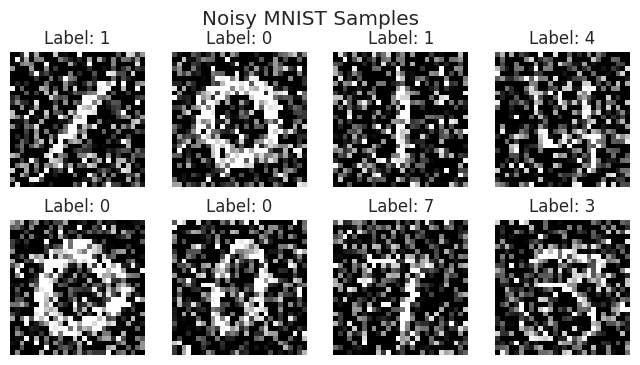


=== Baseline Training (No SMCNmF Reg) ===


/tmp/ipykernel_36/1388145121.py:86: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/tmp/ipykernel_36/1388145121.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/tmp/ipykernel_36/1388145121.py:125: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/5 | train_loss=0.5134 train_acc=0.8372 | val_loss=0.2359 val_acc=0.9233
Epoch 2/5 | train_loss=0.1801 train_acc=0.9429 | val_loss=0.1715 val_acc=0.9468
Epoch 3/5 | train_loss=0.1186 train_acc=0.9616 | val_loss=0.1542 val_acc=0.9493
Epoch 4/5 | train_loss=0.0799 train_acc=0.9748 | val_loss=0.1604 val_acc=0.9515
Epoch 5/5 | train_loss=0.0528 train_acc=0.9834 | val_loss=0.1799 val_acc=0.9463

=== Training with SMCNmF-Inspired Regularizer (lam=0.001) ===
Epoch 1/5 | train_loss=0.5667 train_acc=0.8318 | val_loss=0.2531 val_acc=0.9198
Epoch 2/5 | train_loss=0.2380 train_acc=0.9386 | val_loss=0.1827 val_acc=0.9405
Epoch 3/5 | train_loss=0.1867 train_acc=0.9559 | val_loss=0.1727 val_acc=0.9439
Epoch 4/5 | train_loss=0.1615 train_acc=0.9656 | val_loss=0.1696 val_acc=0.9460
Epoch 5/5 | train_loss=0.1444 train_acc=0.9723 | val_loss=0.1607 val_acc=0.9483

Summary:
     model  final_train_loss  final_train_acc  final_val_loss  final_val_acc  fc1_frobenius  fc1_nuclear  fc1_effective_rank
  

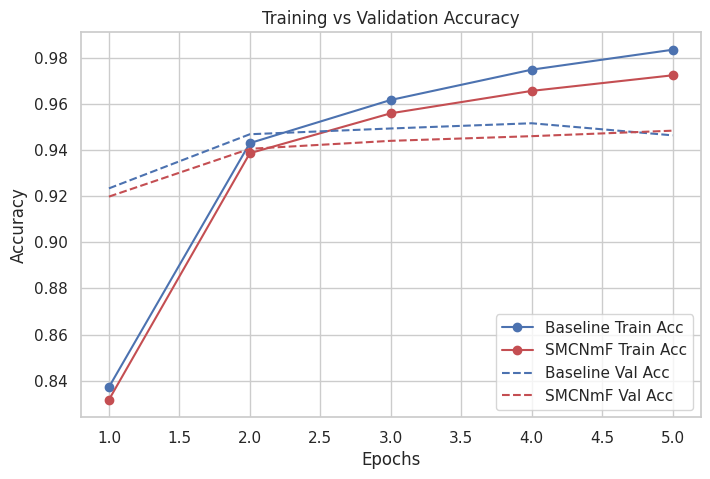

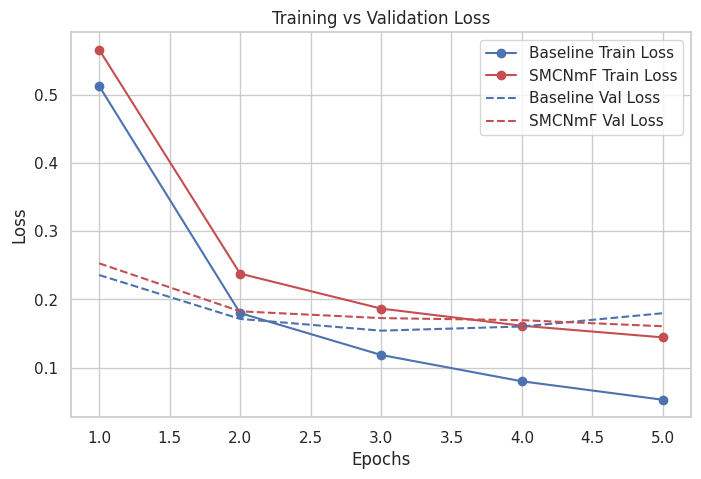

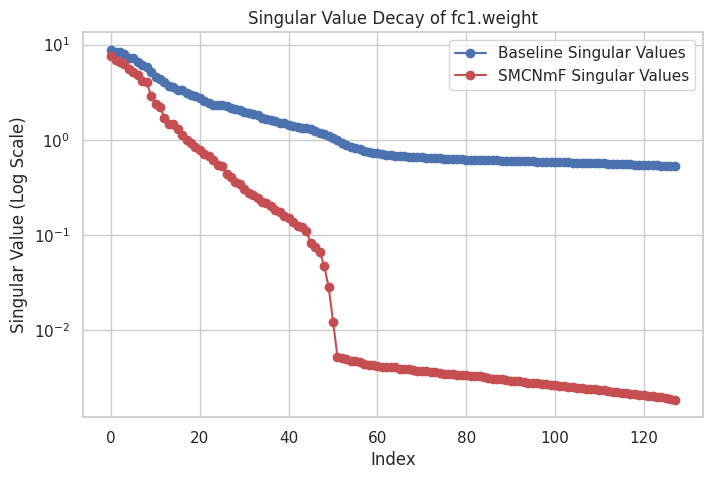

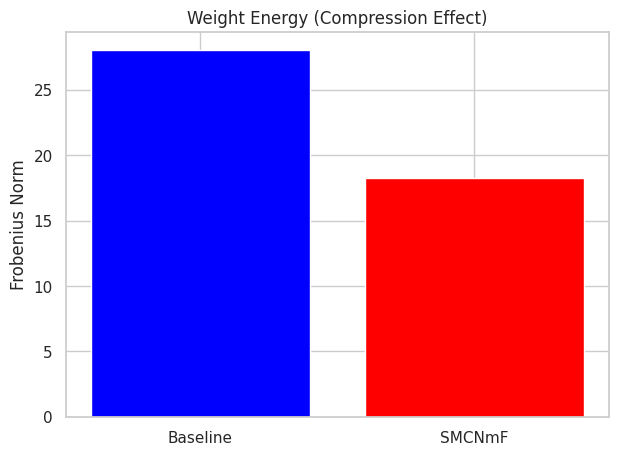

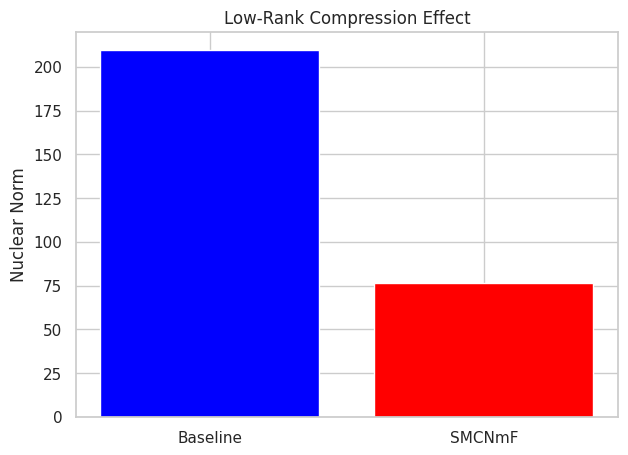


Saved 'cnn_baseline_noisy.pth' and 'cnn_smcnmf_noisy.pth' in current folder.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_df  = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

X = train_df.drop("label", axis=1).values
y = train_df["label"].values

X = X.reshape(-1, 1, 28, 28) / 255.0
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

def add_noise(images, noise_factor=0.5):
    """Add Gaussian noise to images."""
    noise = torch.randn_like(images) * noise_factor
    noisy_imgs = images + noise
    noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)  # keep in [0,1]
    return noisy_imgs

noise_factor = 0.5
X_noisy = add_noise(X, noise_factor=noise_factor)

X_train, X_val, y_train, y_val = train_test_split(X_noisy, y, test_size=0.2, random_state=42)

train_ds = TensorDataset(X_train, y_train)
val_ds   = TensorDataset(X_val, y_val)
test_ds  = torch.tensor(test_df.values.reshape(-1, 1, 28, 28) / 255.0, dtype=torch.float32)

batch_size = 256 if torch.cuda.is_available() else 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size*2, shuffle=False, num_workers=2, pin_memory=True)

plt.figure(figsize=(8, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(X_noisy[i][0], cmap="gray")
    plt.title(f"Label: {y[i].item()}")
    plt.axis("off")
plt.suptitle("Noisy MNIST Samples")
plt.show()

class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*14*14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def smcnmf_regularizer(weight_tensor, lam=1e-3):
    W = weight_tensor.view(weight_tensor.shape[0], -1).double()
    s = torch.linalg.svdvals(W)
    nuclear = torch.sum(s)
    frob = torch.norm(W, p='fro')
    return lam * (nuclear - frob)

def effective_rank(singular_values, thresh=1e-3):
    return (singular_values > thresh).sum().item()

def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=5, lam_reg=0.0):
    model = model.to(device)
    scaler = GradScaler()
    history = {'epoch': [], 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for ep in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()

            with autocast():
                out = model(xb)
                loss = criterion(out, yb)
                if lam_reg > 0:
                    reg = smcnmf_regularizer(model.fc1.weight, lam=lam_reg)
                    loss = loss + reg.to(loss.device).float()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * xb.size(0)
            _, preds = torch.max(out, 1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                with autocast():
                    out = model(xb)
                    loss = criterion(out, yb)
                val_loss += loss.item() * xb.size(0)
                _, preds = torch.max(out, 1)
                correct += (preds == yb).sum().item()
                total += xb.size(0)

        val_loss = val_loss / total
        val_acc = correct / total

        history['epoch'].append(ep)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {ep}/{epochs} | "
              f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

    return model, history

torch.manual_seed(0)
model_base = SmallCNN()
opt_base = optim.AdamW(model_base.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()
print("\n=== Baseline Training (No SMCNmF Reg) ===")
model_base, hist_base = train_model(model_base, opt_base, crit, train_loader, val_loader, epochs=5, lam_reg=0.0)

torch.manual_seed(0)
model_reg = SmallCNN()
opt_reg = optim.AdamW(model_reg.parameters(), lr=1e-3)
lam = 1e-3
print(f"\n=== Training with SMCNmF-Inspired Regularizer (lam={lam}) ===")
model_reg, hist_reg = train_model(model_reg, opt_reg, crit, train_loader, val_loader, epochs=5, lam_reg=lam)

with torch.no_grad():
    Wb = model_base.fc1.weight.data.clone().view(model_base.fc1.weight.shape[0], -1).double()
    Wr = model_reg.fc1.weight.data.clone().view(model_reg.fc1.weight.shape[0], -1).double()
    sb = torch.linalg.svdvals(Wb)
    sr = torch.linalg.svdvals(Wr)

    summary = {
        'model': ['baseline', 'smcnmf_reg'],
        'final_train_loss': [hist_base['train_loss'][-1], hist_reg['train_loss'][-1]],
        'final_train_acc': [hist_base['train_acc'][-1], hist_reg['train_acc'][-1]],
        'final_val_loss': [hist_base['val_loss'][-1], hist_reg['val_loss'][-1]],
        'final_val_acc': [hist_base['val_acc'][-1], hist_reg['val_acc'][-1]],
        'fc1_frobenius': [torch.norm(Wb, 'fro').item(), torch.norm(Wr, 'fro').item()],
        'fc1_nuclear': [sb.sum().item(), sr.sum().item()],
        'fc1_effective_rank': [effective_rank(sb, 1e-3), effective_rank(sr, 1e-3)]
    }
    df = pd.DataFrame(summary)
    print("\nSummary:")
    print(df.to_string(index=False))

sns.set(style="whitegrid")
epochs = hist_base['epoch']

plt.figure(figsize=(8,5))
plt.plot(epochs, hist_base['train_acc'], 'b-o', label="Baseline Train Acc")
plt.plot(epochs, hist_reg['train_acc'], 'r-o', label="SMCNmF Train Acc")
plt.plot(epochs, hist_base['val_acc'], 'b--', label="Baseline Val Acc")
plt.plot(epochs, hist_reg['val_acc'], 'r--', label="SMCNmF Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, hist_base['train_loss'], 'b-o', label="Baseline Train Loss")
plt.plot(epochs, hist_reg['train_loss'], 'r-o', label="SMCNmF Train Loss")
plt.plot(epochs, hist_base['val_loss'], 'b--', label="Baseline Val Loss")
plt.plot(epochs, hist_reg['val_loss'], 'r--', label="SMCNmF Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.semilogy(sb.cpu().numpy(), 'b-o', label="Baseline Singular Values")
plt.semilogy(sr.cpu().numpy(), 'r-o', label="SMCNmF Singular Values")
plt.xlabel("Index")
plt.ylabel("Singular Value (Log Scale)")
plt.title("Singular Value Decay of fc1.weight")
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.bar(['Baseline', 'SMCNmF'], [torch.norm(Wb,'fro').item(), torch.norm(Wr,'fro').item()], color=['blue','red'])
plt.ylabel("Frobenius Norm")
plt.title("Weight Energy (Compression Effect)")
plt.show()

plt.figure(figsize=(7,5))
plt.bar(['Baseline', 'SMCNmF'], [sb.sum().item(), sr.sum().item()], color=['blue','red'])
plt.ylabel("Nuclear Norm")
plt.title("Low-Rank Compression Effect")
plt.show()

torch.save(model_base.state_dict(), "cnn_baseline_noisy.pth")
torch.save(model_reg.state_dict(), "cnn_smcnmf_noisy.pth")
print("\nSaved 'cnn_baseline_noisy.pth' and 'cnn_smcnmf_noisy.pth' in current folder.")
